In [ ]:
def Spectrum_response_ac(T, Sa):
    """
    This function is designed to retrieve the 
    spectral response for any zone globally
    Args:
    T: two times
    Sa: Pseudoaceleration
    """
    import numpy as np
    import pylab as plt
    a = T[1]*Sa[1]
    t = np.linspace(T[1], 2, 1000)
    y = a/t

    plt.plot([0, T[0]],[Sa[0], Sa[1]], color='black')
    plt.plot([T[0], T[1]],[Sa[1], Sa[1]], color='black')
    plt.plot(t, y, color='black')
    plt.title('Espectro de pseudo-aceleraciones')
    plt.ylabel('$S_a$ [g]')
    plt.xlabel('$T$ [s]')
    plt.grid()
    a = plt.show()
    return a

def Spectrum_response_def(T, Sa):
    """
    This function is designed to retrieve the 
    spectral deformation response for any zone globally
    Args:
    T: two times
    Sa: Pseudoaceleration
    """
    import numpy as np
    import pylab as plt

    b = (Sa[1]-Sa[0])/T[0]
    c = Sa[1]
    a = T[1]*Sa[1]

    t1 = np.linspace(0, T[0], 1000)
    t2 = np.linspace(T[0], T[1], 1000)
    t3 = np.linspace(T[1], 2, 1000)

    y1 = 9.81*b*(((t1**3)/(2*np.pi)**2)+(Sa[0]*(t1/(2*np.pi))**2))
    y2 = 9.81*c*(t2/(2*np.pi))**2
    y3 = 9.81*a*(t3/(2*np.pi)**2)

    plt.plot(t1, y1*100, color='black')
    plt.plot(t2, y2*100, color='black')
    plt.plot(t3, y3*100, color='black')
    plt.title('Espectro de pseudo-desplazamientos')
    plt.ylabel('$S_d$ [cm]')
    plt.xlabel('$T$ [s]')
    plt.grid()
    a = plt.show()
    return a

def Dynamic_properties(k, m):
    """
    This function was created to obtain certain dynamic properties to subsequently
    obtain the dynamic response of the structure
      Args:
      k: Stiffness matrix
      m: mass matrix
      Return:
      intensity: Participation factors
      omega: Natural frequencies of each mode of vibration
      modes: Modes of vibration
    """
    import numpy as np
    from scipy.linalg import eig
    eigvals = eig(k, m)[0]
    eigvecs = eig(m, k)[1]
    omega = np.sqrt(np.real(eigvals))
    omega = sorted(omega) # reorganized frequencies
    omega = np.array(omega)
    freq = (2*np.pi)/omega
    Fp = [] # arrays to save the info of participation factor
    modes = []

    for i in range(len(eigvecs)):
        column = eigvecs[:,i].reshape(-1,1)
        col_max = np.max(column)
        col_min = np.min(column)
        if abs(col_max)-abs(col_min)<0:
            column = column/col_min
        else:
            column = column/col_max
        modes.append(column)

    for i in range(len(eigvals)):
        Mo = 0
        Lo = 0
        for j in range(len(eigvals)):
            Mo += m[j][j]*modes[i][j][0]**2
            Lo += m[j][j]*modes[i][j][0]
        so = Lo/Mo
        Fp.append(so)

    return omega, freq, modes, Fp

def inertia(op, b, h=0):
    """
    This function is designed to obtain inertia of the columns, according to the form
    geometric
    Args:
    op: Option geometry of column [1: rectangle, 2: circle, 3: square]
    b: slide 1 (if option 2 it's diameter of circle)
    h: slide 2 (if it's rectangle)
    """
    import numpy as np
    if op==1:
        I = (b*h**3)/12      
    elif op==2:
        I = (1/64)*(np.pi)*(b**4)
    elif op==3:      
        I = (b**4)/12
    else:
        a = print("Inertia not compatible")
        I = a      
    return I

def k_matrix(E, I, L, nc, p):
    """
    This function is designed to obtain the stiffness matrix of the structure based 
    on the number of columns and floors; it also outputs this matrix
    Args:
    E: Modulus of elasticity
    I: Moment of inertia of the cross-section
    L: Length of the columns
    nc: numbers of columns
    p: numbers of floors
    """
    import numpy as np
    k = np.zeros([p+1, p+1])
    el = nc*(12*(E*I)/(L**3))
    kp = el*np.array([[1, -1],
                      [-1, 1]])
    for i in range(0, p):
        k[i:i+2, i:i+2] += kp
    k = k[1:p+1, 1:p+1]
    return k

def m_matrix(m, p):
    """
    This function is performed to obtain the mass matrix of any dynamic problem
    Args:
    m: concentrated mass
    p: number of floors
    """
    import numpy as np
    m_m = np.zeros([p, p])      
    for i in range(0, p):
        m_m[i, i] += m
    return m_m

def calculation_Sa(T_nature, T, Sa):
    """
    This function is used to determine the Sa values corresponding to the 
    structure at its different periods associated with the vibration modes
    Args:
    T_nature: Periods nature
    T: two times
    Sa: Pseudoaceleration
    """
    import numpy as np # import numpy to function
    Sa_T = []
    for i in range(len(T_nature)):
        if T_nature[i] < T[0]:
            a = (Sa[1]-Sa[0])/T[0]
            Sa_T.append(
                Sa[0]+a*T_nature[i]
            )
        elif T_nature[i] < T[1]:
            Sa_T.append(Sa[1])
        else:
            a = T[1]*Sa[1]
            Sa_T.append(
                a/T_nature[i]
            )
    return Sa_T


def results(T, Sa, k, m, L):
    """
    This function is performed to obtain the maximum displacement 
    of the structure, as well as the corresponding maximum drift, and
    shear and bending moment
    Args:
    T: two times
    Sa: Pseudoaceleration
    k: stiffness matrix
    m: mass matrix
    L: length
    """
    import numpy as np # import numpy to function
    omega, Tp, modes, Fp = Dynamic_properties(k, m)

    displacement = []

    # displacement of structure

    g = 9.81 # gravity

    for i in range(len(Tp)):
        if Tp[i] < T[0]:
            y = (Sa[1]-Sa[0])/T[0]
            y = g*y
            Sac = y*Tp[i]+Sa[0]*g # spectrum aceleration to calculation
            Sd = (Sac/(omega[i]**2))*Fp[i]
            displacement.append(modes[i]*Sd)
        elif Tp[i] < T[1]:
            y = Sa[1]
            y = y*g # spectrum aceleration to calculation
            Sd = (y/(omega[i]**2))*Fp[i]
            displacement.append(modes[i]*Sd)
        else:
            a = T[1]*Sa[1]
            a = a*g
            Sac = a/Tp[i] # spectrum aceleration to calculation
            Sd = (Sac/(omega[i]**2))*Fp[i]
            displacement.append(modes[i]*Sd)

    relative_displacement = []

    # relative displacement (derivas)

    for i in range(len(displacement)):
        Sam = []
        for j in range(len(displacement)):
            if i == 0:
                Sam.append(((displacement[j][i])/L)**2)
            else:
                dh = displacement[j][i]-displacement[j][i-1]
                Sam.append((dh/L)**2)
        suml = sum(Sam)**0.5
        relative_displacement.append(suml*100)

    # Shear force

    V = 0

    for i in range(len(displacement)):
        V += sum((float(omega[i])**2)*np.dot(m, displacement[i]))**2
    Vb = V**0.5

    # moment bending

    M = 0
    Ma = []

    for i in range(len(displacement)):
        V = float(omega[i])**2*np.dot(m, displacement[i])
        M = 0
        for j in range(len(V)):
            M += V[j]*(j+1)*L
        Ma.append(M)

    Ma = np.array(Ma)
    M=0

    for i in range(len(displacement)):
        M += Ma[i]**2
        
    M = sum(M)**0.5

    # total displacement of structure

    total_displacement = []

    for i in range(len(displacement)):
        ssc = 0
        for j in range(len(displacement)):
            ssc += displacement[j][i]**2
        total_displacement.append(sum(ssc)**0.5)
        
    return displacement, relative_displacement, Vb, M, total_displacement

def result_test(T, Sa, k, m, L, main_modes):
    """
    This function is performed to obtain the maximum displacement 
    of the structure, as well as the corresponding maximum drift, and
    shear and bending moment, only any main modes
    Args:
    T: two times
    Sa: Pseudoaceleration
    k: stiffness matrix
    m: mass matrix
    L: length
    main_modes: number main modes (int)
    """
    import numpy as np # import numpy to function 
    omega, Tp, modes = Dynamic_properties(k, m)[0: 3]

    Fp = []

    for i in range(main_modes):
        Mo = 0
        Lo = 0
        for j in range(main_modes):
            Mo += m[j][j]*modes[i][j][0]**2
            Lo += m[j][j]*modes[i][j][0]
        so = Lo/Mo
        Fp.append(so)

    displacement = []

    # displacement of structure

    g = 9.81 # gravity

    for i in range(main_modes):
        if Tp[i] < T[0]:
            y = (Sa[1]-Sa[0])/T[0]
            y = g*y
            Sac = y*Tp[i]+Sa[0]*g # spectrum aceleration to calculation
            Sd = (Sac/(omega[i]**2))*Fp[i]
            displacement.append(modes[i]*Sd)
        elif Tp[i] < T[1]:
            y = Sa[1]
            y = y*g # spectrum aceleration to calculation
            Sd = (y/(omega[i]**2))*Fp[i]
            displacement.append(modes[i]*Sd)
        else:
            a = T[1]*Sa[1]
            a = a*g
            Sac = a/Tp[i] # spectrum aceleration to calculation
            Sd = (Sac/(omega[i]**2))*Fp[i]
            displacement.append(modes[i]*Sd)

    relative_displacement = []

    # relative displacement (derivas)

    for i in range(main_modes):
        Sam = []
        for j in range(len(displacement)):
            if i == 0:
                Sam.append(((displacement[j][i])/L)**2)
            else:
                dh = displacement[j][i]-displacement[j][i-1]
                Sam.append((dh/L)**2)
        suml = sum(Sam)**0.5
        relative_displacement.append(suml*100)
    
    # Shear force

    V = 0

    for i in range(main_modes):
        V += sum((float(omega[i])**2)*np.dot(m, displacement[i]))**2
    Vb = V**0.5

    # moment bending

    M = 0
    Ma = []

    for i in range(main_modes):
        V = float(omega[i])**2*np.dot(m, displacement[i])
        M = 0
        for j in range(len(V)):
            M += V[j]*(j+1)*L
        Ma.append(M)

    Ma = np.array(Ma)
    M=0

    for i in range(len(displacement)):
        M += Ma[i]**2
        
    M = sum(M)**0.5

    # total displacement of structure

    total_displacement = []

    for i in range(len(modes)):
        ssc = 0
        for j in range(len(displacement)):
            ssc += displacement[j][i]**2
        total_displacement.append(sum(ssc)**0.5)

    # Modal participation factor

    mmparticipation = []
    for i in range(main_modes):
        mj = (np.sum(modes[i].T@m)**2)/(modes[i].T@m@modes[i])
        mj /= np.sum(m)
        mmparticipation.append(mj)
    
    mmparticipation = np.cumsum(mmparticipation)
    return displacement, relative_displacement, Vb, M, total_displacement, mmparticipation

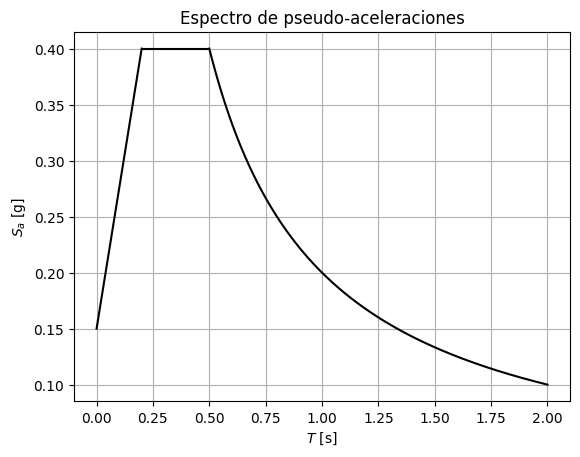

In [216]:
Sa = [0.15, 0.4]
T = [0.2, 0.5]

Spectrum_response_ac(T, Sa)

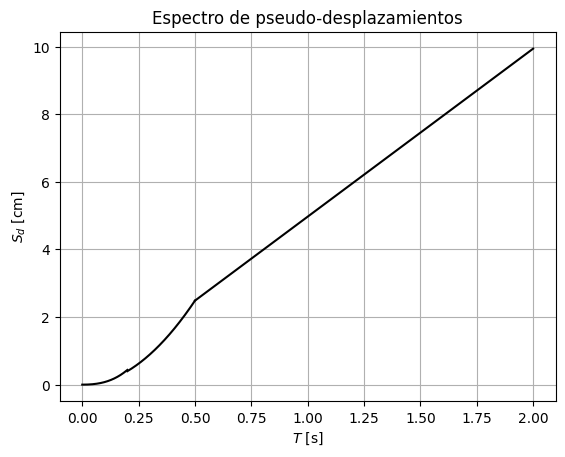

In [217]:
Spectrum_response_def(T, Sa)

In [218]:
# Inputs
wl = 1 # tonf/m²
a = 2*20*20 # m²
ml = wl*a # tonf
E = 2e6*9.81 # tonf/m²
I = inertia(3, 0.4) #m^4
L = 3 # m

k = k_matrix(E, I, L, 36, 5)
m = m_matrix(ml, 5)
a = Dynamic_properties(k, m)

res = result_test(T, Sa, k, m, L, 2) # to test